In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import datetime
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from matplotlib import cm

def is_weekday(date_string):
    date_obj = datetime.datetime.strptime(date_string[:25], "Date: %Y-%m-%d %H:%M:%S")
    return date_obj.weekday() < 5

def get_travel_data(year,depart_hour_range=None,weight_column=None,weekday="All",origin_purp="All",dest_purp="All"):
    df = pd.read_csv("psrc_trips.csv")
    # df = df[(df["d_tract10"].astype(str).str[2:5]=="033")&(df["o_tract10"].astype(str).str[2:5]=="033")]
    df = df[df['depart_time_string'].str[6:10].notna() & df['depart_time_string'].str[17:19].notna()]
    df_2021 = df[(df['depart_time_string'].str[6:10] == str(year))]
    if depart_hour_range != None:
        df_2021 = df_2021[df_2021['depart_time_string'].str[17:19].astype(int).between(*depart_hour_range)]
    df_2021 = df_2021[["o_tract10","d_tract10","origin_purpose_cat","dest_purpose_cat",'depart_time_string',"arrival_time_string","trip_adult_weight_2021","trip_respondent_weight_2021",
                    "trip_weight_2017","trip_weight_2019","trip_weight_2017_2019","trip_adult_weight_2017_2019"]]
    if weight_column == None:
        if year == 2021:
            weight_column = "trip_respondent_weight_2021"
        elif year == 2019:
            weight_column = "trip_weight_2019"
        elif year == 2017:
            weight_column = "trip_weight_2017"
    if weekday=="All":
        pass
    elif weekday==True:
        df_2021 = df_2021[df_2021["depart_time_string"].apply(is_weekday)]
    elif weekday==False:
        df_2021 = df_2021[df_2021["depart_time_string"].apply(is_weekday)]
    if origin_purp=="All":
        pass
    else:
        df_2021 = df_2021[df_2021["origin_purpose_cat"]==origin_purp]
    if dest_purp=="All":
        pass
    else:
        df_2021 = df_2021[df_2021["dest_purpose_cat"]==dest_purp]
    df_2021["d_tract10"] = df_2021["d_tract10"].astype(str).str[:-2]
    df_2021["o_tract10"] = df_2021["o_tract10"].astype(str).str[:-2]
    unique_elements = set(df_2021['o_tract10']).union(set(df_2021['d_tract10']))
    df_2021 = df_2021.groupby(["o_tract10","d_tract10"]).sum(weight_column)
    df_2021 = df_2021.reset_index()
    table_2021 = df_2021.pivot(index='d_tract10', columns='o_tract10', \
                                values=weight_column).reindex(index=unique_elements, \
                                columns=unique_elements, fill_value=0).fillna(0)
    if 'n' in table_2021.index:
        table_2021 = table_2021.drop('n', axis=0)
    if 'n' in table_2021.columns:
        table_2021 = table_2021.drop('n', axis=1)
    table_2021 = table_2021 - table_2021.T
    table_2021_numpy = table_2021.to_numpy()
    table_2021_numpy = np.where(table_2021_numpy < 0, 0, table_2021_numpy)
    non_zero_entries = table_2021_numpy.nonzero()
    non_zero_df = pd.DataFrame({
        'Destination': [table_2021.index[i] for i in non_zero_entries[0]],
        'Origin': [table_2021.columns[i] for i in non_zero_entries[1]],
        'Value': table_2021.to_numpy()[non_zero_entries]
    })
    nodes_list = set(non_zero_df["Destination"]).union(set(non_zero_df["Origin"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in non_zero_df.iterrows()}
    return nodes_list, edges_dict

def delete_element(lst, i):
    lst.pop(i)
    return lst

def generate_circle_positions(n, radius=5):
    positions = {}
    for i in range(n):
        angle = 2 * math.pi * i / n
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        positions[i] = (x, y)
    return positions

def build_graph(nodes,edge_dict):
    internal_nodes_dict = {i:idx+1 for idx,i in enumerate(nodes)}
    internal_edges_dict = {(internal_nodes_dict[edge[0]],internal_nodes_dict[edge[1]]):weight for edge,weight in edge_dict.items()}
    G = nx.Graph()
    G.add_nodes_from(internal_nodes_dict.values())
    for edge in internal_edges_dict.keys():
        src, dst = edge
        weight = internal_edges_dict.get((src, dst))
        if dst > src:
            G.add_edge(src, dst, weight=weight)
        elif dst < src:
            G.add_edge(src, dst, weight=(-1)*weight)
        else:
            pass
    return G, internal_nodes_dict

def get_vertex_by_edge_boundary(G):
    vertices = list(G.nodes)
    edges = list(G.edges)
    vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
    return vertex_by_edge_boundary,vertices,edges

def get_edge_by_triangle_boundary(G):
    edges = list(G.edges)
    triangles = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == 3]
    edges_dict = {edge:idx for idx,edge in enumerate(edges)}
    triangles_dict = {triangle:idx for idx,triangle in enumerate(triangles)}
    data = []
    row_indices = []
    col_indices = []
    for triangle in triangles:
        col_idx = triangles_dict[triangle]
        row_indices.append(edges_dict[(triangle[1],triangle[2])])
        row_indices.append(edges_dict[(triangle[0],triangle[2])])
        row_indices.append(edges_dict[(triangle[0],triangle[1])])
        col_indices.append(col_idx)
        col_indices.append(col_idx)
        col_indices.append(col_idx)
        data.append(1)
        data.append(-1)
        data.append(1)
    data = np.array(data)
    row_indices = np.array(row_indices)
    col_indices = np.array(col_indices)
    edge_by_triangle_boundary = csc_matrix((data, (row_indices, col_indices)), shape=(len(edges), len(triangles)))
    return edge_by_triangle_boundary,edges,triangles

def get_k_simplex_by_k_plus_1_simplex_boundary(G,k):
    k_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == k+1]
    k_plus_1_simplicies = [tuple(clique) for clique in nx.enumerate_all_cliques(G) if len(clique) == k+2]
    k_simplicies_dict = {k_simplex:idx for idx,k_simplex in enumerate(k_simplicies)}
    k_plus_1_simplicies_dict = {k_plus_1_simplex:idx for idx,k_plus_1_simplex in enumerate(k_plus_1_simplicies)}
    data = []
    row_indices = []
    col_indices = []
    for k_plus_1_simplex in k_plus_1_simplicies:
        col_idx = k_plus_1_simplicies_dict[k_plus_1_simplex]
        for i in range(len(k_plus_1_simplex)):
            row_indices.append(k_simplicies_dict[tuple(delete_element(list(k_plus_1_simplex),i))])
            col_indices.append(col_idx)
            data.append((-1)**(i))
    data = np.array(data)
    row_indices = np.array(row_indices)
    col_indices = np.array(col_indices)
    k_simplex_by_k_plus_1_simplex_boundary = csc_matrix((data, (row_indices, col_indices)), shape=(len(k_simplicies), len(k_plus_1_simplicies)))
    return k_simplex_by_k_plus_1_simplex_boundary,k_simplicies,k_plus_1_simplicies

def get_hodge_laplacian(G,k):
    if k == 0:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        hodge_laplacian = k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    elif k >= 1:
        k_by_k_plus_1_bdary,k_simplcies,k_plus_1_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k)
        k_minus_1_by_k_bdary,k_minus_1_simplcies,k_simplicies = get_k_simplex_by_k_plus_1_simplex_boundary(G,k-1)
        hodge_laplacian = k_minus_1_by_k_bdary.T@k_minus_1_by_k_bdary+k_by_k_plus_1_bdary@k_by_k_plus_1_bdary.T
    return hodge_laplacian

def get_graph_laplacian(G):
    return get_hodge_laplacian(G,0)

def get_graph_helmholtzian(G):
    return get_hodge_laplacian(G,1)

def get_graph_hodge_decomposition(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    edge_by_triangle_boundary,edges,triangles = get_edge_by_triangle_boundary(G)
    graph_helmholtzian = get_graph_helmholtzian(G)
    vertices_potential = lsqr(vertex_by_edge_boundary.T, edge_flows)[0]
    vertices_potential = vertices_potential-min(vertices_potential)
    gradient_component = vertex_by_edge_boundary.T@vertices_potential
    triangles_curl = np.linalg.pinv(edge_by_triangle_boundary)@edge_flows
    triangles_curl = lsqr(edge_by_triangle_boundary, edge_flows)[0]
    curl_adjoint_component = edge_by_triangle_boundary@triangles_curl
    graph_helmholtzian_kernel_component = (np.eye(len(edges))-graph_helmholtzian@np.linalg.pinv(graph_helmholtzian))@edge_flows
    three_components = (gradient_component,graph_helmholtzian_kernel_component,curl_adjoint_component)
    three_matrices = (vertex_by_edge_boundary,graph_helmholtzian,edge_by_triangle_boundary)
    return three_components, three_matrices, (vertices_potential,triangles_curl), (vertices,edges,triangles), internal_nodes_dict, edge_flows

def get_graph_closest_potential(nodes,edge_dict):
    G, internal_nodes_dict = build_graph(nodes,edge_dict)
    edge_flows = np.array([data['weight'] for _, _, data in G.edges(data=True)]).T
    vertex_by_edge_boundary,vertices,edges = get_vertex_by_edge_boundary(G)
    vertices_potential = lsqr(vertex_by_edge_boundary.T, edge_flows)[0]
    vertices_potential = vertices_potential-min(vertices_potential)
    gradient_component = vertex_by_edge_boundary.T@vertices_potential
    return gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows

def plot_urban_potential(year,weight_column=None,depart_hour_range=None,weekday="All",origin_purp="All",dest_purp="All"):
    nodes,edge_dict = get_travel_data(year=year,depart_hour_range=depart_hour_range,weight_column=weight_column,weekday=weekday,origin_purp=origin_purp,dest_purp=dest_purp)
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2010/tract10.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    if depart_hour_range != None:
        plt.title(f"{str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 Census Tract Potentials (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"{str(year)} Census Tract Potentials (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    if depart_hour_range != None:
        plt.title(f"Histogram of Census Tract Potential Values {str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"Histogram of Census Tract Potential Values {str(year)} (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence(year,weight_column=None,depart_hour_range=None,weekday="All",origin_purp="All",dest_purp="All"):
    nodes,edge_dict = get_travel_data(year=year,depart_hour_range=depart_hour_range,weight_column=weight_column,weekday=weekday,origin_purp=origin_purp,dest_purp=dest_purp)
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2010/tract10.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID10"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID10", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    divergence_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(divergence_vals, 0.1), vmax=np.quantile(divergence_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    if depart_hour_range != None:
        plt.title(f"{str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 Census Tract Divergences (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"{str(year)} Census Tract Divergences (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    if depart_hour_range != None:
        plt.title(f"Histogram of Census Tract Divergence Values {str(year)} {str(depart_hour_range[0])}:00:00 to {str(depart_hour_range[1])}:00:00 (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    else:
        plt.title(f"Histogram of Census Tract Divergence Values {str(year)} (weekday={weekday},origin_purp={origin_purp},dest_purp={dest_purp})")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [24]:
def get_travel_data_2():
    df = pd.read_csv("wa_od_main_JT00_2021.csv")
    # df = pd.read_csv("oh_od_main_JT00_2021.csv")
    # df = pd.read_csv("id_od_main_JT00_2021.csv")
    # df = pd.read_csv("nm_od_main_JT00_2021.csv")
    # df = pd.read_csv("wi_od_main_JT00_2021.csv")
    fips_dict = {"King":53033,"Snohomish":53061,"Pierce":53053,"Thurston":53067,
                 "Kitsap":53035,"Skagit":53057,"Island":53029,"Lewis":53041,"Mason":53045}
    # fips_dict = {"King":53033}
    # fips_dict = {"Franklin":39049}
    # fips_dict = {"Ada":16001}
    # fips_dict = {"Bernalillo":35001}
    # fips_dict = {"Wilwaukee":55079}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_3():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_3():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_4():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'New Mexico census tract 2017/tl_2017_35_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_4():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'New Mexico census tract 2017/tl_2017_35_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_6():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Ohio census tract 2019/tl_2019_39_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [6]:
def get_travel_data_2():
    df = pd.read_csv("wa_od_main_JT00_2021.csv")
    fips_dict = {"King":53033,"Snohomish":53061,"Pierce":53053,"Thurston":53067,
                 "Kitsap":53035,"Skagit":53057,"Island":53029,"Lewis":53041,"Mason":53045}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Negative Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_2_3d():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    for idx, tract in gdf_10_2.iterrows():
        boundary = tract['geometry'].boundary
        x = [point.x for point in boundary]
        y = [point.y for point in boundary]
        height = tract['Potential']
        color = cm.viridis(norm(height))
        ax.bar3d(x, y, [0] * len(x), 
                height, 0.1, 0.1, 
                color=color, alpha=0.5) 
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Potential')
    ax.set_title('3D Choropleth Map 2021 Census Tract Commute Negative Potentials')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_potential_df["Divergence"], vertices_divergence_potential_df["Potential"], color='blue', marker='o')
    plt.title(f"Histogram of Census Tract Commute Divergence and Negative Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    # plt.xlim([-3000,10000])
    # plt.ylim([-1,15])
    plt.grid(True)
    plt.show()

def get_urban_divergence_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_potential_df.to_csv("Seattle census tract divergence potential.csv")


In [7]:
get_urban_divergence_potential_2()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


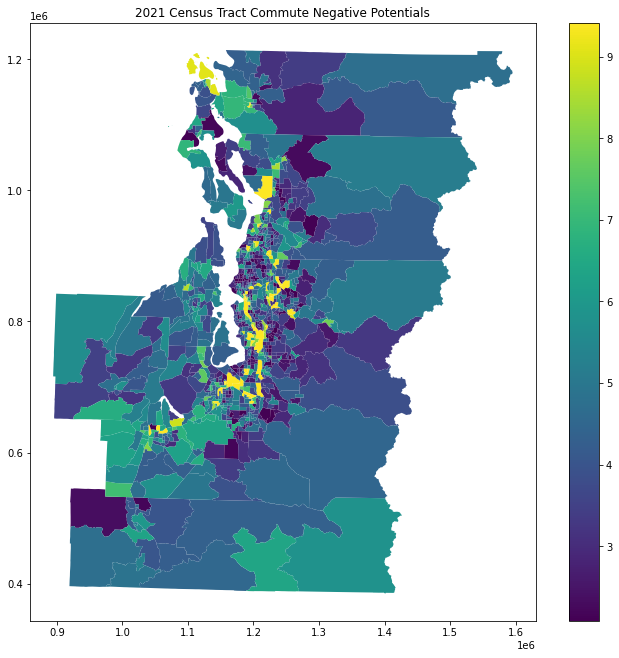

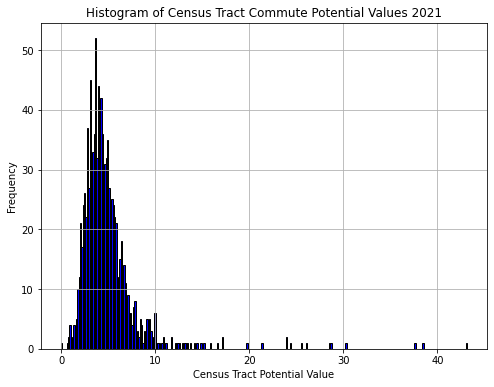

In [28]:
plot_urban_potential_2()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


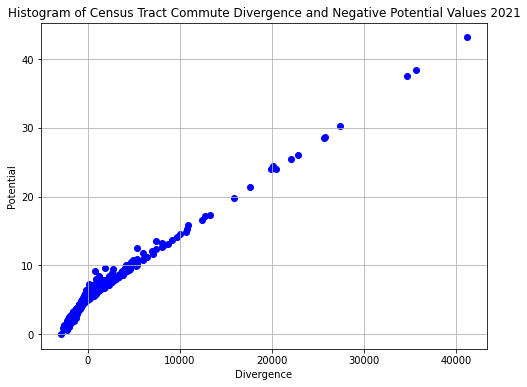

In [31]:
plot_urban_divergence_potential_2()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


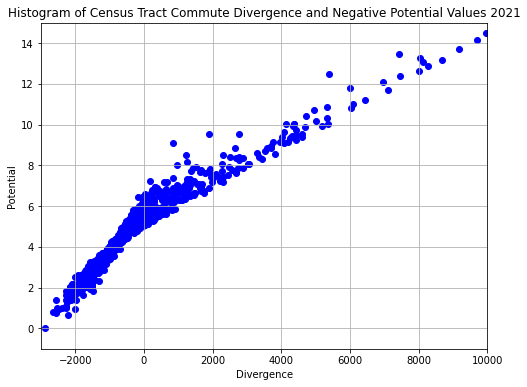

In [29]:
plot_urban_divergence_potential_2()

In [32]:
def get_travel_data_2():
    df = pd.read_csv("wa_od_main_JT00_2021.csv")
    fips_dict = {"King":53033,"Snohomish":53061,"Pierce":53053}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Negative Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Negative Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_potential_df["Divergence"], vertices_divergence_potential_df["Potential"], color='blue', marker='o')
    plt.title(f"Histogram of Census Tract Commute Divergence and Negative Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    # plt.xlim([-3000,10000])
    # plt.ylim([-1,15])
    plt.grid(True)
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


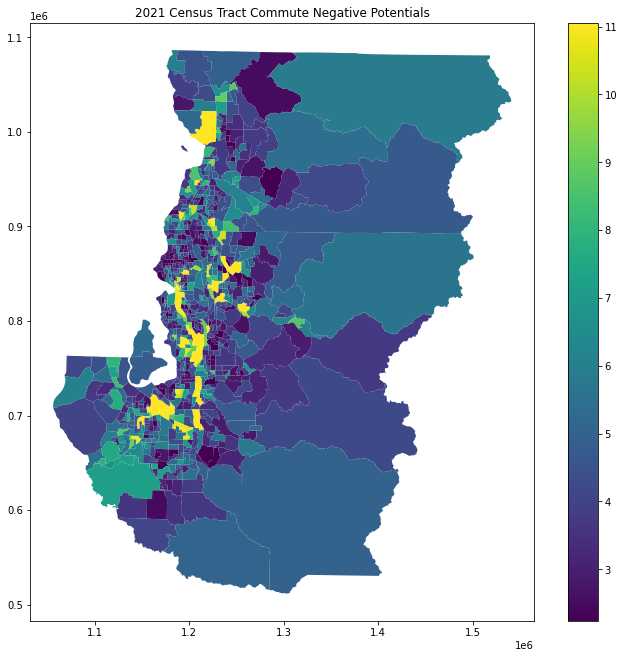

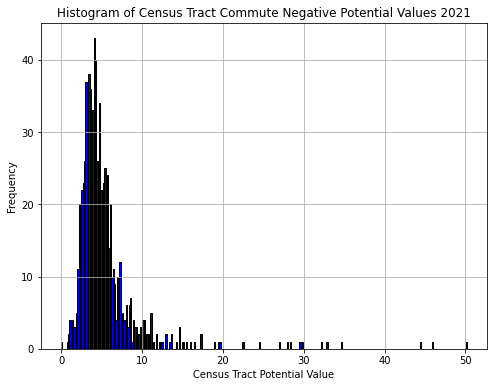

In [33]:
plot_urban_potential_2()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


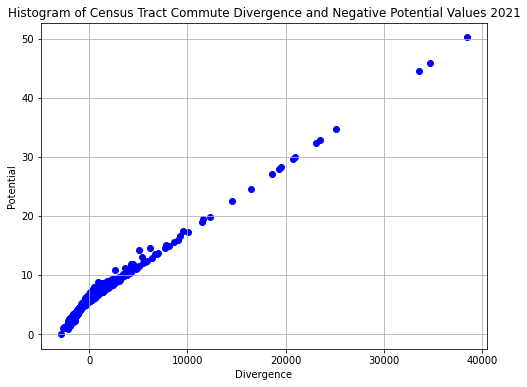

In [34]:
plot_urban_divergence_potential_2()

In [37]:
def get_travel_data_2():
    df = pd.read_csv("wa_od_main_JT00_2021.csv")
    fips_dict = {"King":53033}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.03), vmax=np.quantile(potential_vals, 0.97))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Negative Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Negative Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'census tracts 2020/tract20.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID20"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID20", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.03), vmax=np.quantile(potential_vals, 0.97))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_2():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_potential_df["Divergence"], vertices_divergence_potential_df["Potential"], color='blue', marker='o')
    plt.title(f"Histogram of Census Tract Commute Divergence and Negative Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    # plt.xlim([-3000,10000])
    # plt.ylim([-1,15])
    plt.grid(True)
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


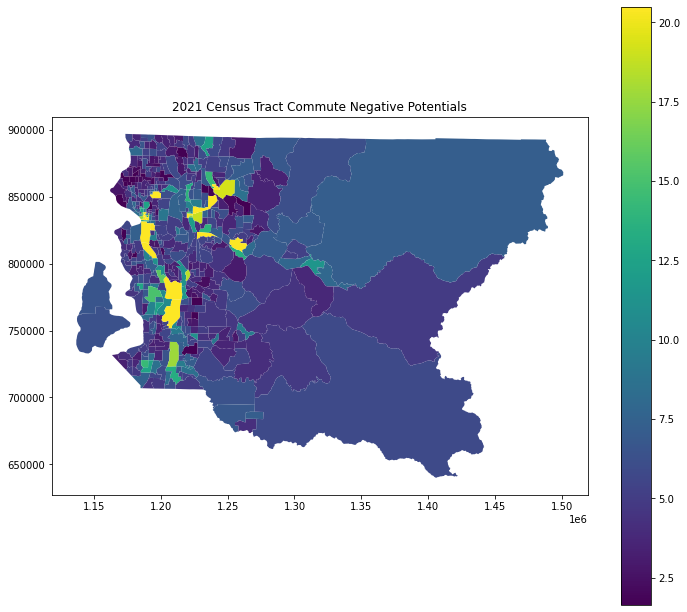

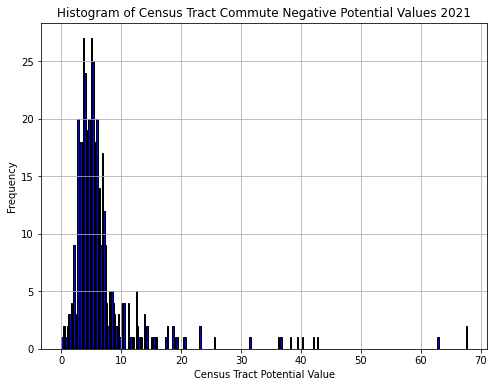

In [38]:
plot_urban_potential_2()

In [ ]:
plot_urban_divergence_2()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


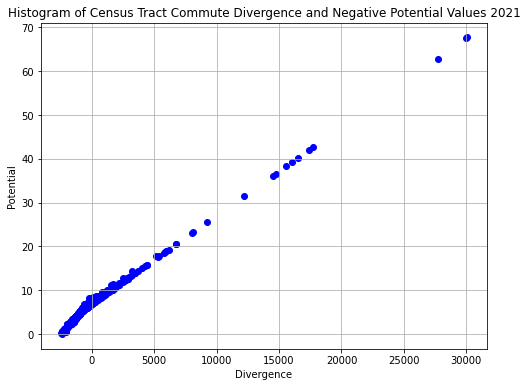

In [39]:
plot_urban_divergence_potential_2()

In [4]:
def get_travel_data_2():
    df = pd.read_csv("id_od_main_JT00_2021.csv")
    # fips_dict = {"Ada":16001, "Boise":16015, "Canyon":16027, "Gem":16045,"Owyhee":16073}
    fips_dict = {"Ada":16001, "Boise":16015}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_3():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_potential_3_3d():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.05), vmax=np.quantile(potential_vals, 0.95))
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    for idx, tract in gdf_10_2.iterrows():
        boundary = tract['geometry'].boundary
        x = [point.x for point in boundary]
        y = [point.y for point in boundary]
        height = tract['Potential']
        color = cm.viridis(norm(height))
        ax.bar3d(x, y, [0] * len(x), 
                height, 0.1, 0.1, 
                color=color, alpha=0.5) 
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Potential')
    ax.set_title('3D Choropleth Map 2021 Census Tract Commute Negative Potentials')
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_3():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Idaho census tract 2023/tl_2023_16_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\2615605000.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\2615605000.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


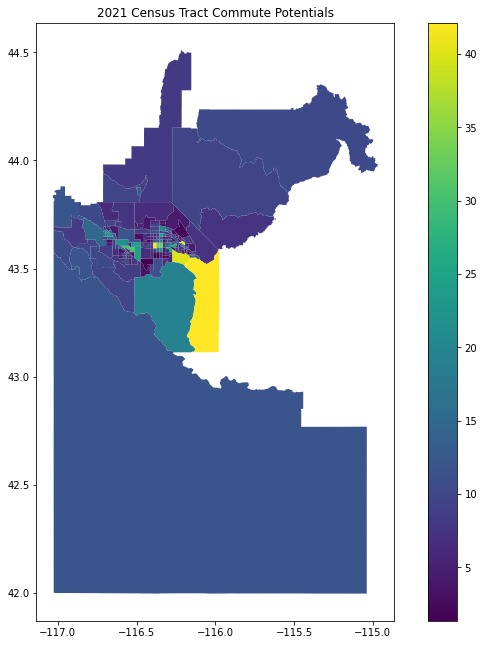

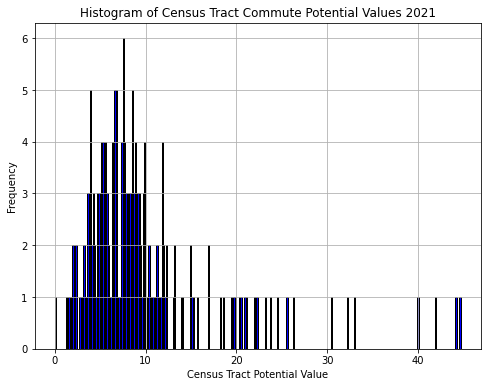

In [33]:
plot_urban_potential_3()

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1355347496.py:128: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1355347496.py:129: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


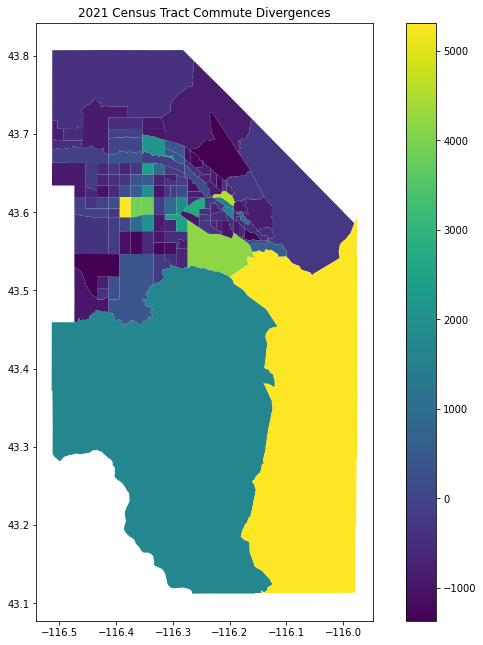

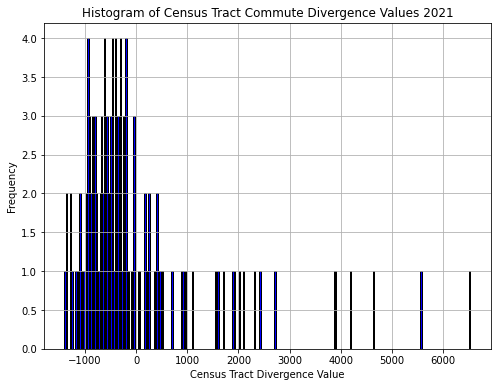

In [37]:
plot_urban_divergence_3()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\403980163.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\403980163.py:60: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


TypeError: 'LineString' object is not iterable

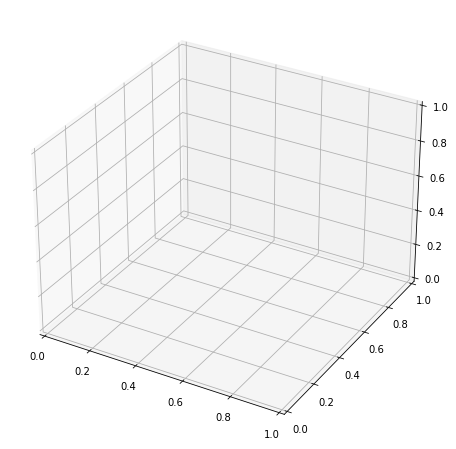

In [5]:
plot_urban_potential_3_3d()

C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1896637803.py:157: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1896637803.py:158: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1896637803.py:163: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

ValueError: cannot convert float NaN to integer

<Figure size 864x792 with 1 Axes>

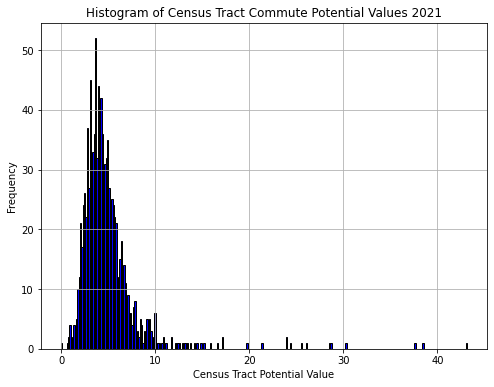

In [26]:
plot_urban_potential_4()

C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\3763837937.py:102: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True).todense()
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1875099598.py:187: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_2672\1875099598.py:188: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


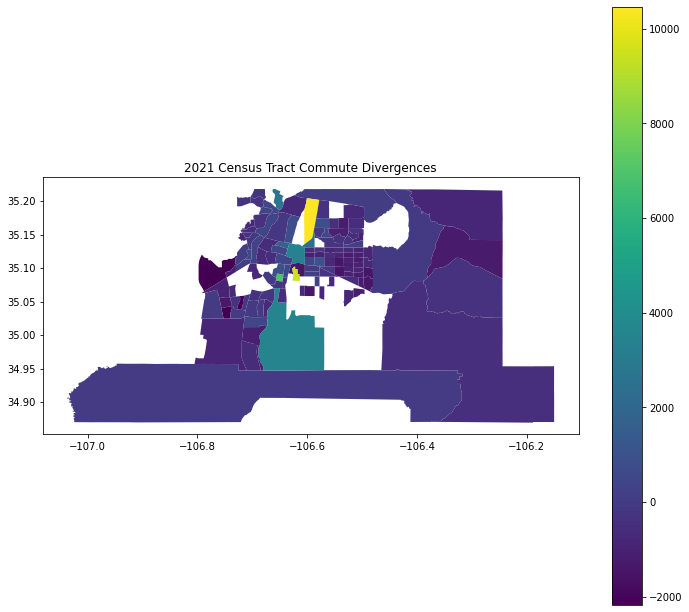

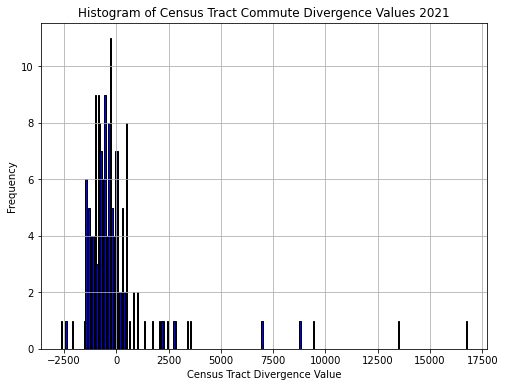

In [40]:
plot_urban_divergence_4()

In [10]:
def get_travel_data_2():
    df = pd.read_csv("wi_od_main_JT00_2021.csv")
    fips_dict = {"Wilwaukee":55079,"Waukesha":55133,"Washington":55131,"Ozaukee":55089,"Racine":55101,"Dodge":55027,"Jefferson":55055,"Walworth":55127}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_greater_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.05)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.05)
    plt.title(f"Histogram of Census Tract Commute Divergence and Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    plt.xlim([-2500,7500])
    plt.ylim([-1,20])
    plt.grid(True)
    plt.show()

def get_urban_divergence_potential_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_potential_df.to_csv("Milwaukee census tract divergence potential.csv")


C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1672460131.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1672460131.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


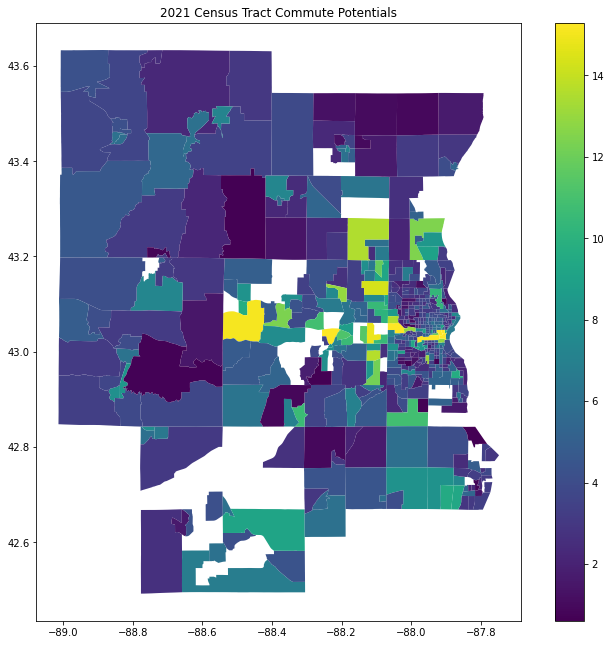

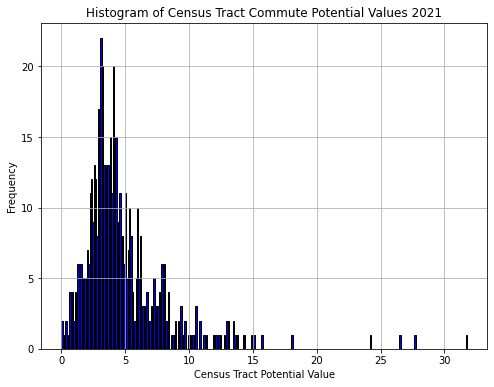

In [28]:
plot_urban_potential_5()

C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1672460131.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1672460131.py:60: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


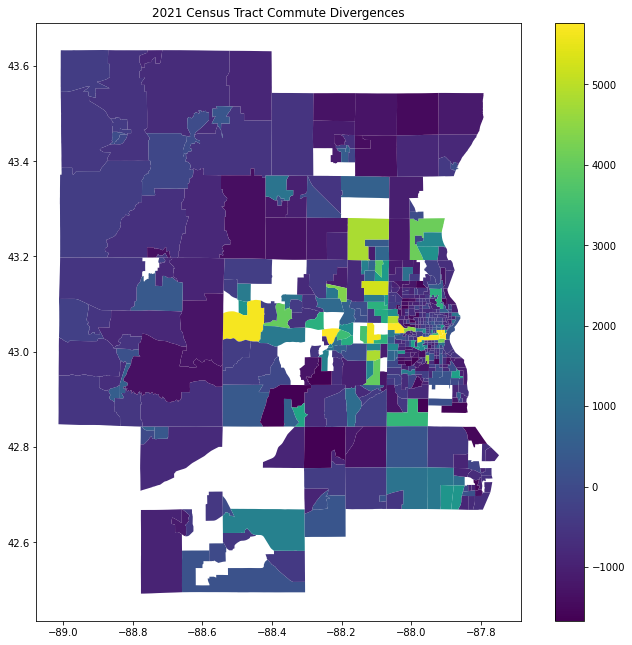

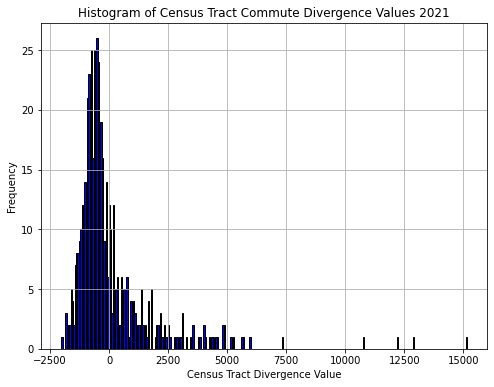

In [29]:
plot_urban_divergence_5()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


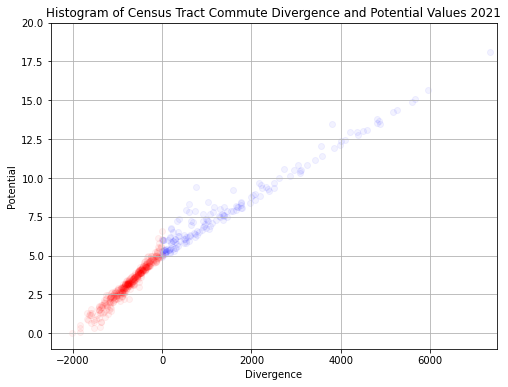

In [11]:
plot_urban_divergence_potential_5()

In [12]:
get_urban_divergence_potential_5()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


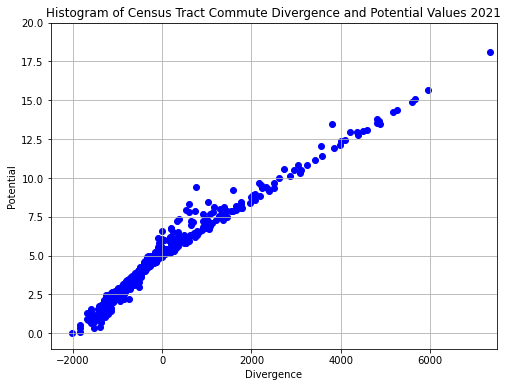

In [19]:
plot_urban_divergence_potential_5()

In [13]:


def get_travel_data_2():
    df = pd.read_csv("oh_od_main_JT00_2021.csv")
    fips_dict = {"Franklin":39049,"Delaware":39041,"Licking":39089,"Fairfield":39045,"Union":39159,"Pickaway":39129,"Madison":39097,"Perry":39127,"Morrow":39117,"Hocking":39073}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_6():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Ohio census tract 2019/tl_2019_39_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_6():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_greater_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.05)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.05)
    plt.title(f"Histogram of Census Tract Commute Divergence and Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    plt.xlim([-4000,10000])
    plt.ylim([-5,30])
    plt.grid(True)
    plt.show()

def get_urban_divergence_potential_6():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_potential_df.to_csv("Columbus census tract divergence potential.csv")

C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\318728462.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\318728462.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


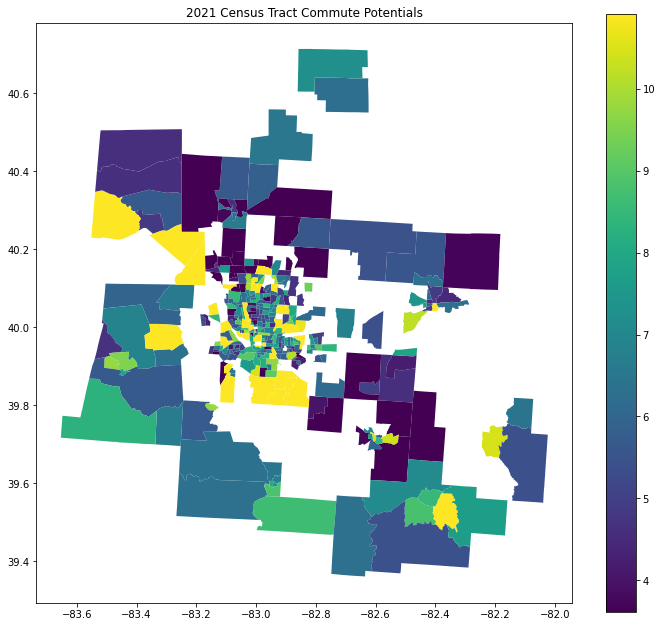

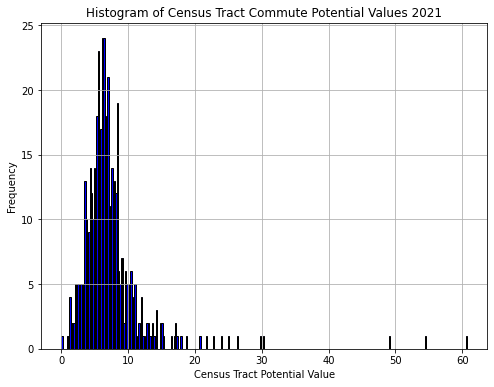

In [31]:
plot_urban_potential_6()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


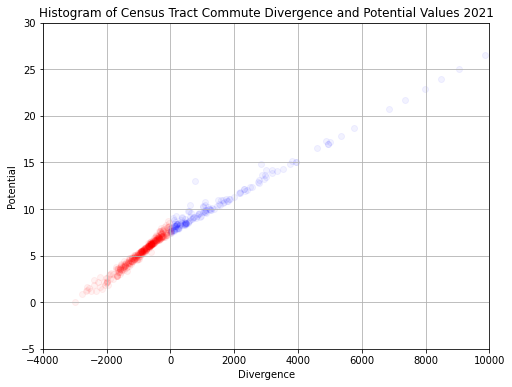

In [14]:
plot_urban_divergence_potential_6()

In [15]:
get_urban_divergence_potential_6()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


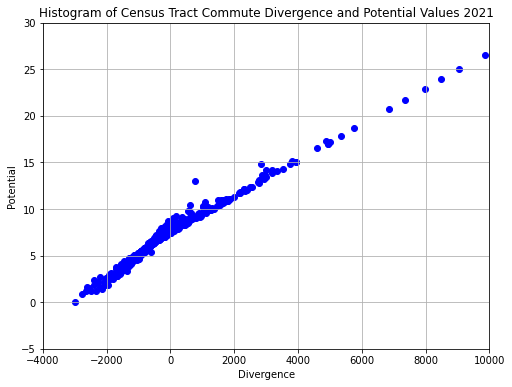

In [15]:
plot_urban_divergence_potential_6()

In [ ]:
def plot_urban_potential_5():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Wisconsin census tract 2018/tl_2018_55_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [35]:
def get_travel_data_2():
    df = pd.read_csv("il_od_main_JT00_2018.csv")
    fips_dict = {"Cook":17031, "DuPage":17043, "Grundy":17063, "McHenry":17111,"Will":17197,"DeKalb":17037,"Kane":17089,"Kendall":17093,"Lake":17097}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

get_urban_divergence_potential_2()

C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\4116790845.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\4116790845.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


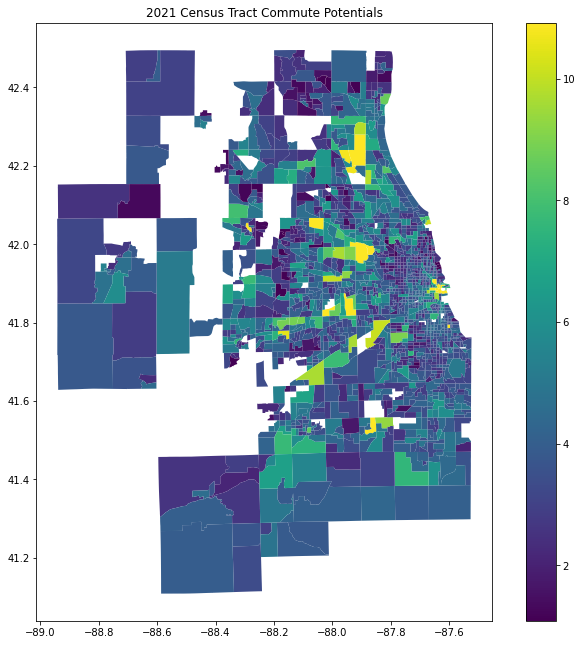

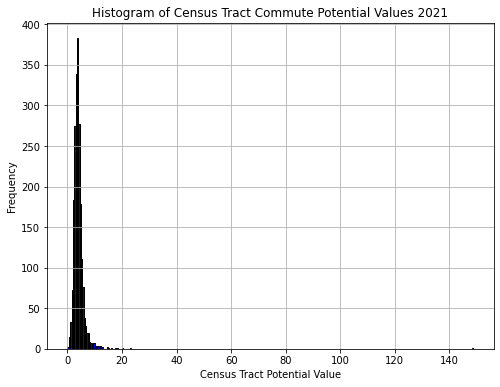

In [36]:
plot_urban_potential_7()

In [8]:
def get_travel_data_2():
    df = pd.read_csv("il_od_main_JT00_2018.csv")
    fips_dict = {"Cook":17031, "DuPage":17043, "Grundy":17063, "McHenry":17111,"Will":17197}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def get_urban_divergence_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_potential_df.to_csv("Chicago census tract divergence potential.csv")

In [9]:
get_urban_divergence_potential_7()

C:\Users\DELL\AppData\Local\Temp\ipykernel_9160\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\4011040430.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_30440\4011040430.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


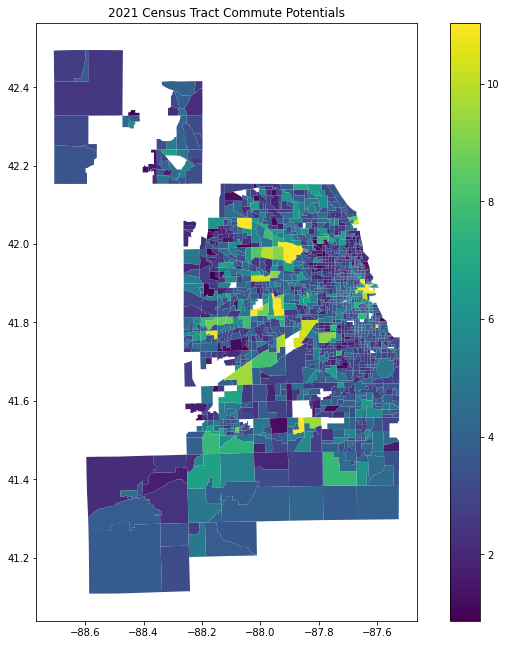

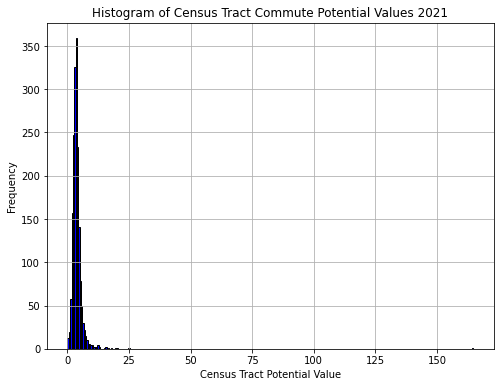

In [38]:
plot_urban_potential_7()

In [78]:
def get_travel_data_2():
    df = pd.read_csv("il_od_main_JT00_2018.csv")
    fips_dict = {"Cook":17031, "DuPage":17043}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Negative Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Negative Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_greater_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.05)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.05)
    plt.title(f"Histogram of Census Tract Commute Divergence and Negative Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    plt.xlim([-5000,5000])
    plt.ylim([-5,10])
    plt.grid(True)
    plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\61443273.py:29: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\61443273.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


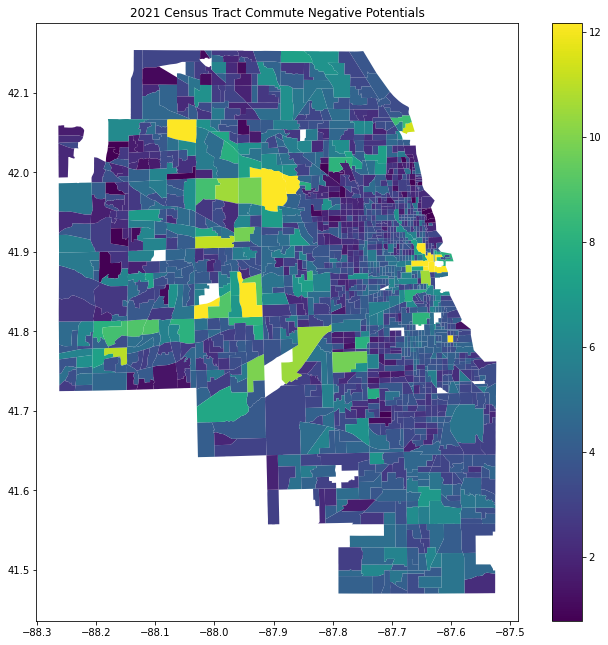

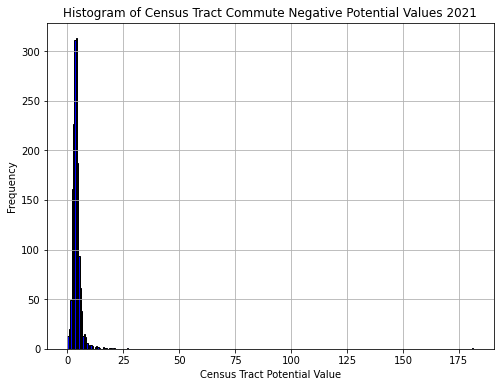

In [41]:
plot_urban_potential_7()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)
C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\61443273.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\61443273.py:60: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_10['YCOORD'] = gdf_10.geometry.centroid.y


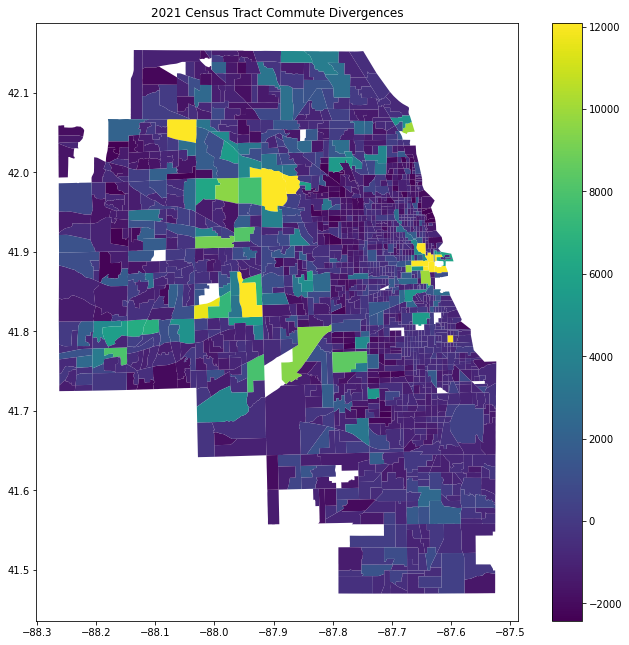

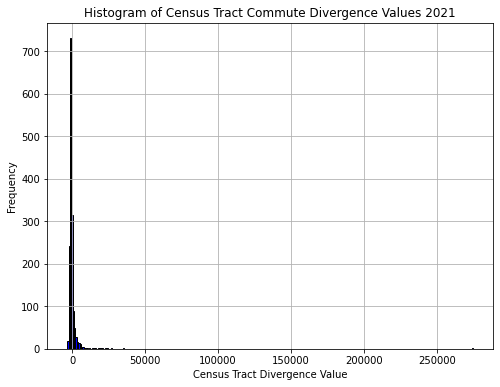

In [42]:
plot_urban_divergence_7()

C:\Users\DELL\AppData\Local\Temp\ipykernel_20040\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


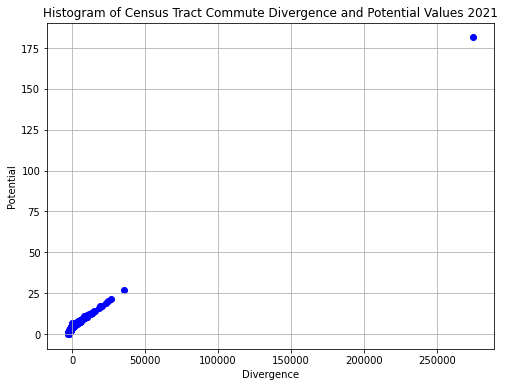

In [8]:
plot_urban_divergence_potential_7()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


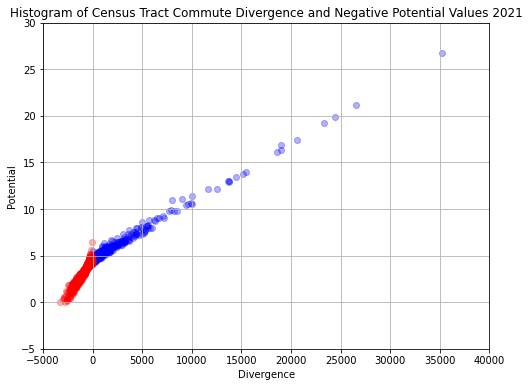

In [77]:
plot_urban_divergence_potential_7()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


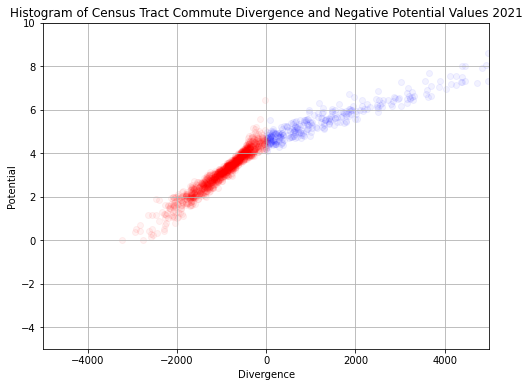

In [79]:
plot_urban_divergence_potential_7()

In [44]:
nodes,edge_dict = get_travel_data_2()
gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
graph_laplacian = vertex_by_edge_boundary@vertex_by_edge_boundary.T
graph_laplacian

C:\Users\DELL\AppData\Local\Temp\ipykernel_16196\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


<1550x1550 sparse array of type '<class 'numpy.float64'>'
	with 1017128 stored elements in Compressed Sparse Column format>

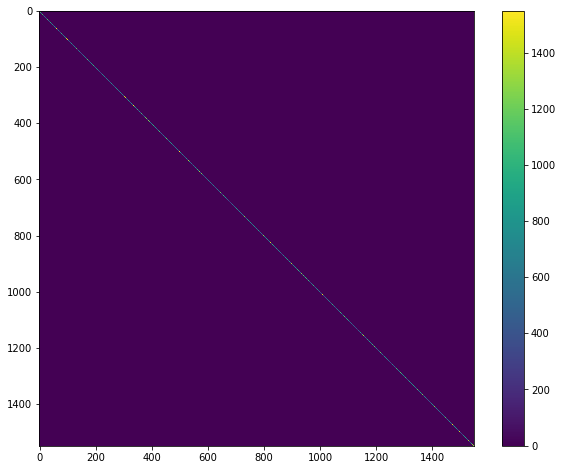

In [50]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
dense_matrix = graph_laplacian.toarray()
plt.imshow(dense_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

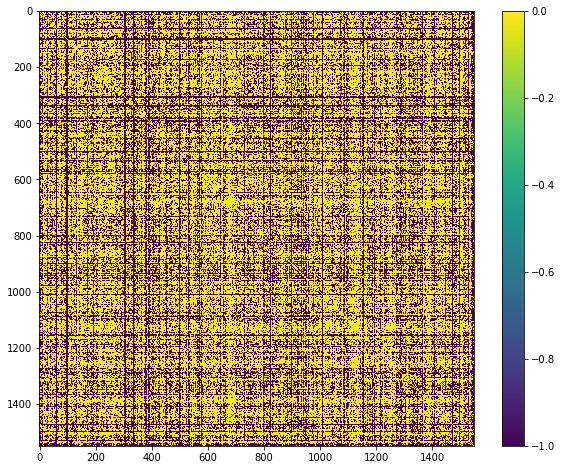

In [53]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
dense_matrix = (graph_laplacian-np.diag(graph_laplacian.diagonal()))
plt.imshow(dense_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

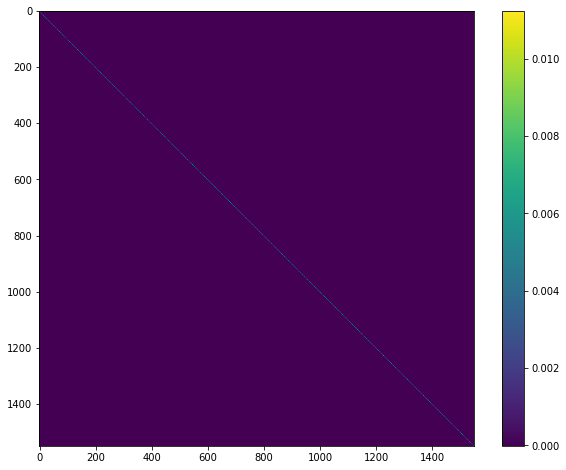

In [55]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
dense_matrix = np.linalg.pinv(graph_laplacian.toarray())
plt.imshow(dense_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

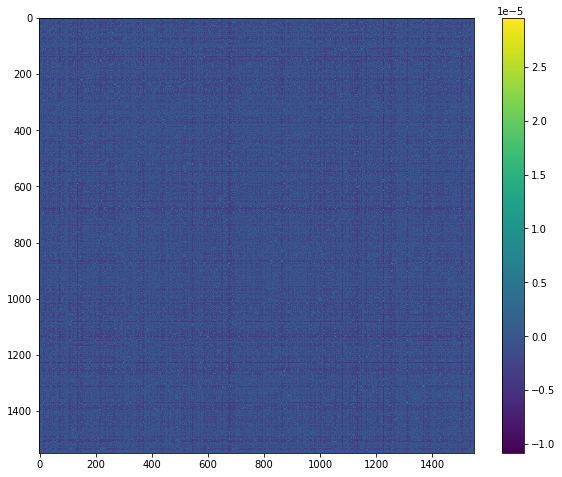

In [56]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
dense_matrix = np.linalg.pinv(graph_laplacian.toarray())
dense_matrix = dense_matrix - np.diag(np.diag(dense_matrix))
plt.imshow(dense_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [62]:
np.max(dense_matrix)

2.9528144492523834e-05

In [63]:
np.min(dense_matrix)

-1.0812255444811978e-05

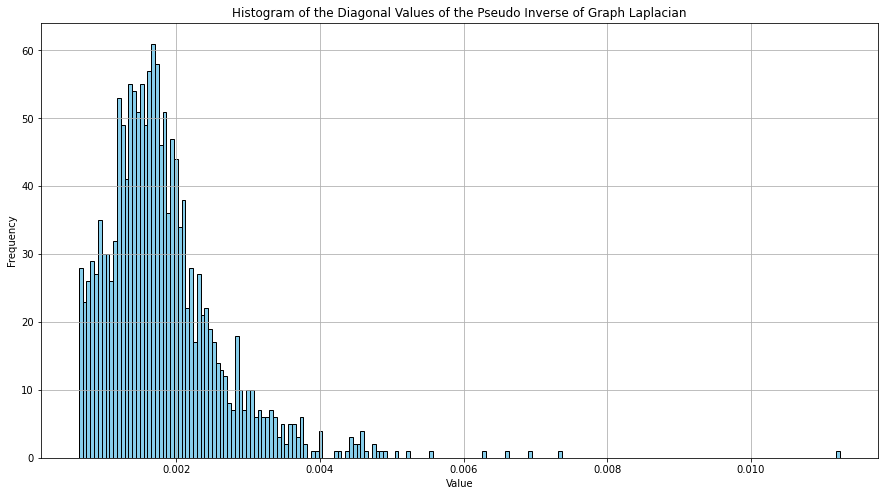

In [66]:
plt.figure(figsize=(15, 8))
plt.hist(np.diag(np.linalg.pinv(graph_laplacian.toarray())), bins=200, color='skyblue', edgecolor='black')
plt.title('Histogram of the Diagonal Values of the Pseudo Inverse of Graph Laplacian')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

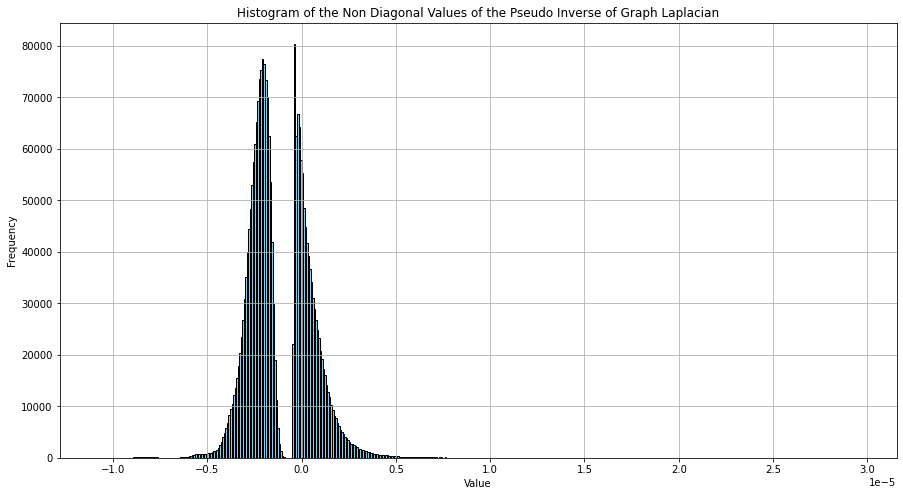

In [67]:
plt.figure(figsize=(15, 8))
plt.hist(dense_matrix.flatten(), bins=500, color='skyblue', edgecolor='black')
plt.title('Histogram of the Non Diagonal Values of the Pseudo Inverse of Graph Laplacian')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

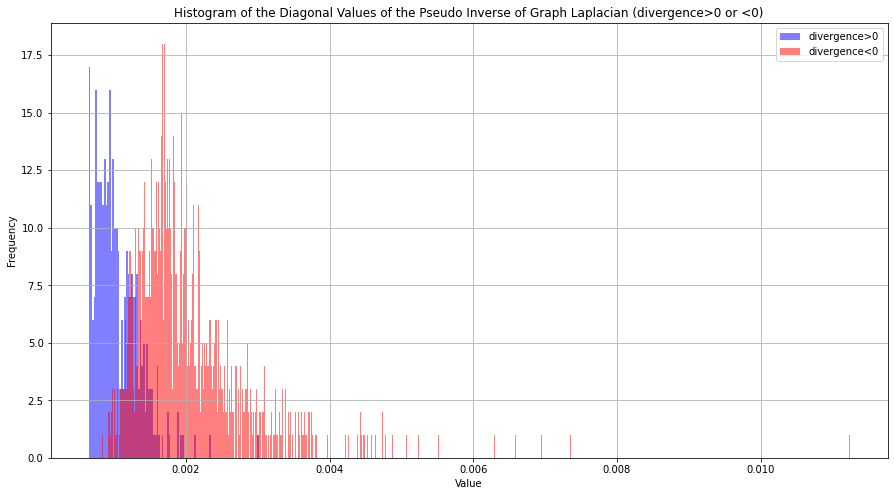

In [70]:
vertices_divergence = graph_laplacian@vertices_potential>0
values = np.diag(np.linalg.pinv(graph_laplacian.toarray()))
values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
plt.figure(figsize=(15, 8))
plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
plt.hist(values_false, bins=1000, color='red', alpha=0.5, label='divergence<0')
plt.title('Histogram of the Diagonal Values of the Pseudo Inverse of Graph Laplacian (divergence>0 or <0)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

The above is interpreted as the slope of the line in the divergence-potential plot. We see that there are two peaks for divergence>0 and divergence<0, which expalins why the divergence-potential plot looks like piecewise linear function

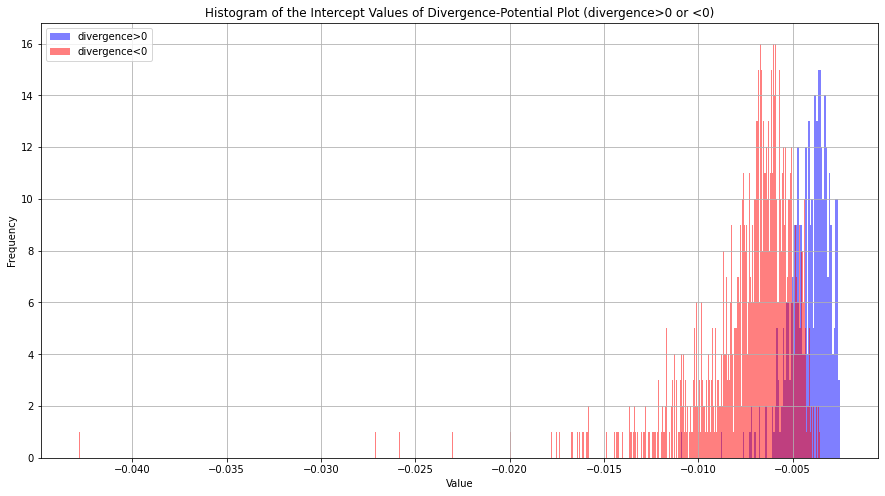

In [72]:
values = dense_matrix@vertices_potential
values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
plt.figure(figsize=(15, 8))
plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
plt.hist(values_false, bins=1000, color='red', alpha=0.5, label='divergence<0')
plt.title('Histogram of the Intercept Values of Divergence-Potential Plot (divergence>0 or <0)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
nodes,edge_dict = get_travel_data_2()
gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
vertex_by_edge_boundary.shape

C:\Users\DELL\AppData\Local\Temp\ipykernel_20040\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


(1550, 507789)

In [18]:
from scipy.sparse.linalg import svds

n = min(vertex_by_edge_boundary.shape)
u, s, vt = svds(vertex_by_edge_boundary, k=n-1)

In [17]:
n

1550

In [14]:
s

array([39.26826907, 39.26838348, 39.34463519, 39.35733055, 39.35734709,
       39.37003937])

In [1]:
def get_travel_data_2():
    df = pd.read_csv("il_od_main_JT00_2018.csv")
    fips_dict = {"Cook":17031, "DuPage":17043, "Grundy":17063, "McHenry":17111,"Will":17197,"DeKalb":17037,"Kane":17089,"Kendall":17093,"Lake":17097}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Negative Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Negative Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_divergence_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_divergence_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_divergence_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Divergence", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Divergences")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_divergence_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Divergence Values 2021")
    plt.xlabel("Census Tract Divergence Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_greater_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.05)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.05)
    plt.title(f"Histogram of Census Tract Commute Divergence and Negative Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    plt.xlim([-5000,5000])
    plt.ylim([-5,10])
    plt.grid(True)
    plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_15392\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


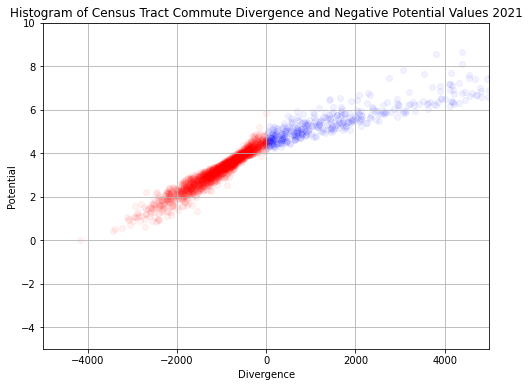

In [4]:
plot_urban_divergence_potential_7()

In [5]:
nodes,edge_dict = get_travel_data_2()
gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
graph_laplacian = vertex_by_edge_boundary@vertex_by_edge_boundary.T
graph_laplacian

C:\Users\DELL\AppData\Local\Temp\ipykernel_15392\1814674707.py:104: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


<2103x2103 sparse array of type '<class 'numpy.float64'>'
	with 1709459 stored elements in Compressed Sparse Column format>

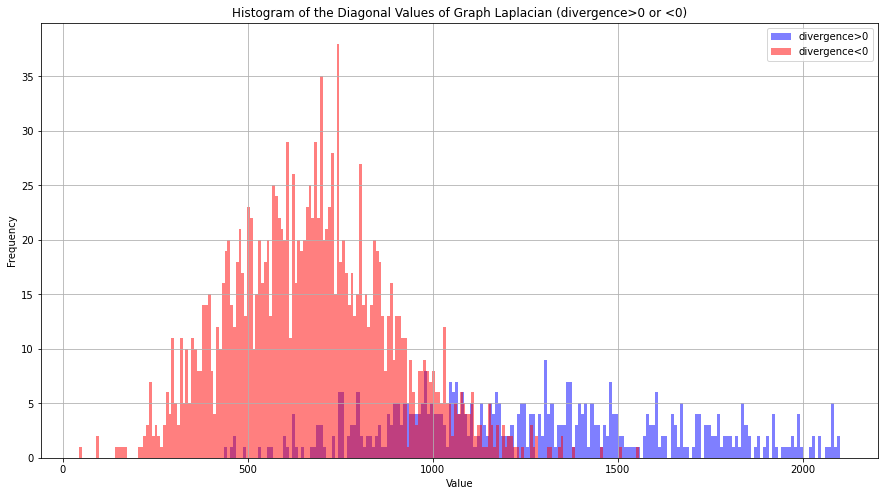

In [22]:
vertices_divergence = graph_laplacian@vertices_potential>0
values = np.diag(graph_laplacian.toarray())
values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
plt.figure(figsize=(15, 8))
plt.hist(values_true, bins=200, color='blue', alpha=0.5, label='divergence>0')
plt.hist(values_false, bins=200, color='red', alpha=0.5, label='divergence<0')
plt.title('Histogram of the Diagonal Values of Graph Laplacian (divergence>0 or <0)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

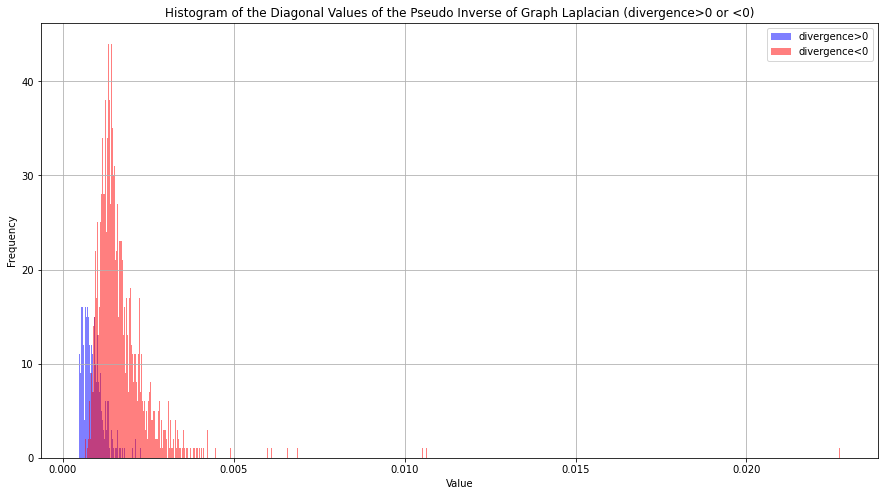

In [6]:
vertices_divergence = graph_laplacian@vertices_potential>0
values = np.diag(np.linalg.pinv(graph_laplacian.toarray()))
values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
plt.figure(figsize=(15, 8))
plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
plt.hist(values_false, bins=1000, color='red', alpha=0.5, label='divergence<0')
plt.title('Histogram of the Diagonal Values of the Pseudo Inverse of Graph Laplacian (divergence>0 or <0)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

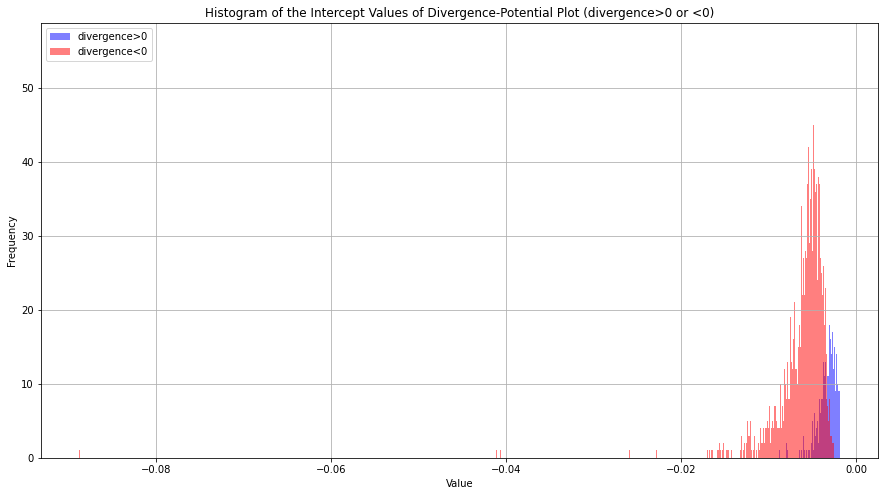

In [8]:
dense_matrix = np.linalg.pinv(graph_laplacian.toarray())
dense_matrix = dense_matrix - np.diag(np.diag(dense_matrix))
values = dense_matrix@vertices_potential
values_true = [values[i] for i in range(len(values)) if vertices_divergence[i]]
values_false = [values[i] for i in range(len(values)) if not vertices_divergence[i]]
plt.figure(figsize=(15, 8))
plt.hist(values_true, bins=100, color='blue', alpha=0.5, label='divergence>0')
plt.hist(values_false, bins=1000, color='red', alpha=0.5, label='divergence<0')
plt.title('Histogram of the Intercept Values of Divergence-Potential Plot (divergence>0 or <0)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

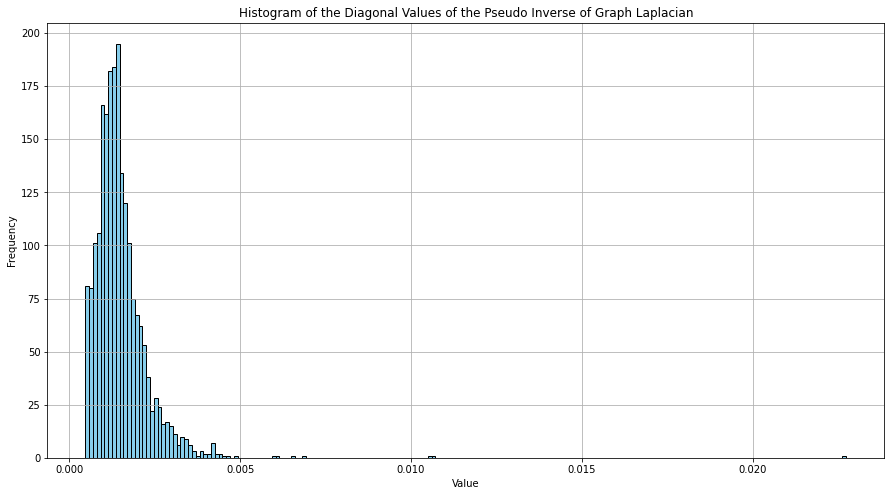

In [9]:
plt.figure(figsize=(15, 8))
plt.hist(np.diag(np.linalg.pinv(graph_laplacian.toarray())), bins=200, color='skyblue', edgecolor='black')
plt.title('Histogram of the Diagonal Values of the Pseudo Inverse of Graph Laplacian')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

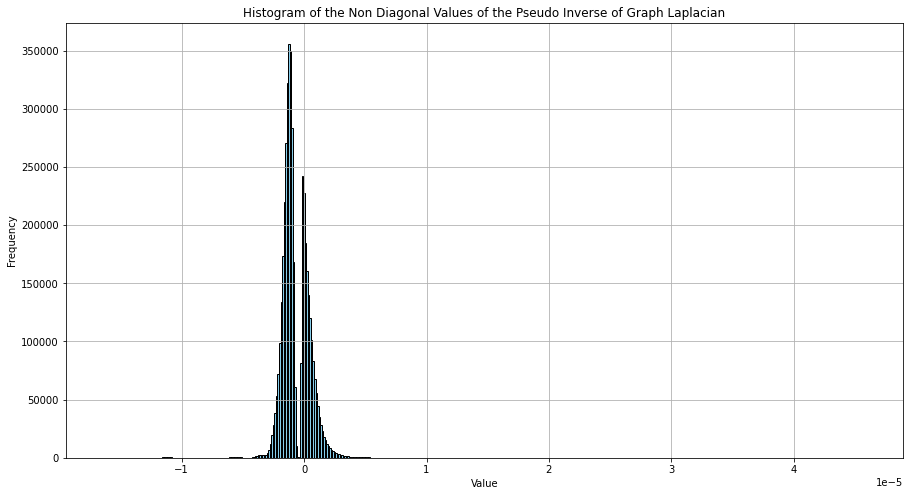

In [10]:
plt.figure(figsize=(15, 8))
plt.hist(dense_matrix.flatten(), bins=500, color='skyblue', edgecolor='black')
plt.title('Histogram of the Non Diagonal Values of the Pseudo Inverse of Graph Laplacian')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

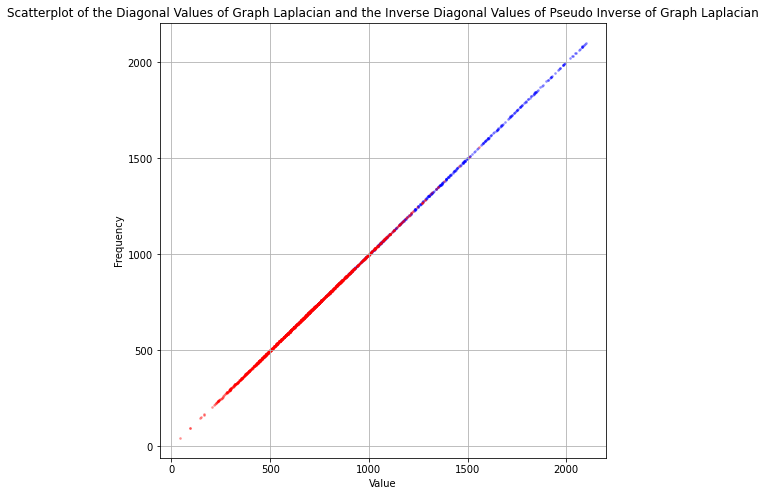

In [18]:
plt.figure(figsize=(8, 8))
x = np.diag(graph_laplacian.toarray())
y = np.diag(np.linalg.pinv(graph_laplacian.toarray()))**(-1)
plt.scatter(x[vertices_divergence],y[vertices_divergence], color='blue', label='divergence>0', s=3, alpha=0.3)
plt.scatter(x[~vertices_divergence],y[~vertices_divergence], color='red', label='divergence<0', s=3, alpha=0.3)
plt.title('Scatterplot of the Diagonal Values of Graph Laplacian and the Inverse Diagonal Values of Pseudo Inverse of Graph Laplacian')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

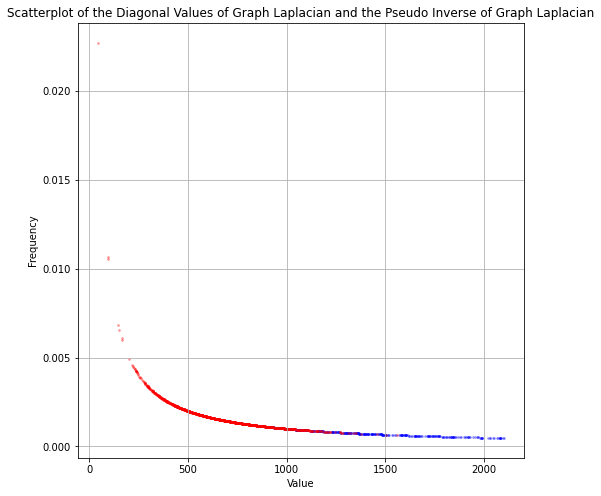

In [17]:
plt.figure(figsize=(8, 8))
x = np.diag(graph_laplacian.toarray())
y = np.diag(np.linalg.pinv(graph_laplacian.toarray()))
plt.scatter(x[vertices_divergence],y[vertices_divergence], color='blue', label='divergence>0', s=3, alpha=0.3)
plt.scatter(x[~vertices_divergence],y[~vertices_divergence], color='red', label='divergence<0', s=3, alpha=0.3)
plt.title('Scatterplot of the Diagonal Values of Graph Laplacian and the Pseudo Inverse of Graph Laplacian')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
def get_travel_data_2():
    df = pd.read_csv("il_od_main_JT00_2018.csv")
    fips_dict = {"Cook":17031, "DuPage":17043, "Grundy":17063, "McHenry":17111,"Will":17197}
    fips_list = list(str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'Illinois census tract 2018/tl_2018_17_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.01), vmax=np.quantile(potential_vals, 0.99))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2021 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2021")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def get_urban_divergence_potential_7():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_potential_df.to_csv("Chicago census tract divergence potential.csv")

In [2]:
def get_travel_data_2():
    df = pd.read_csv("ca_od_main_JT00_2019.csv")
    fips_dict = {"San Francisco":6075,"Sonoma":6097 ,"Solano":6095 ,"Santa Clara":6085,"San Mateo":6081,"Napa":6055,"Marin":6041,"Contra Costa":6013,"Alameda":6001}
    fips_list = list("0"+str(i) for i in fips_dict.values())
    df["w_geocode_first5_str"] = df["w_geocode"].astype(str).str[:5]
    df["h_geocode_first5_str"] = df["h_geocode"].astype(str).str[:5]
    df = df[df["h_geocode_first5_str"].isin(fips_list) & df["w_geocode_first5_str"].isin(fips_list)]
    df = df[["w_geocode","h_geocode","S000"]]
    df["w_geocode_first11_str"] = df["w_geocode"].astype(str).str[:11]
    df["h_geocode_first11_str"] = df["h_geocode"].astype(str).str[:11]
    df = df.groupby(["w_geocode_first11_str","h_geocode_first11_str"])['S000'].sum().reset_index()
    # df = df[df["S000"]>3]
    nodes_list = set(df["w_geocode_first11_str"]).union(set(df["h_geocode_first11_str"]))
    edges_dict = {(row[1],row[0]):row[2] for index, row in df.iterrows()}
    return nodes_list, edges_dict

def plot_urban_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_potential_df = pd.DataFrame({
            'Census Tract': vertices_potential_dict.keys(),
            'Potential': vertices_potential_dict.values()
        })
    shapefile_path = 'California census tract 2019/tl_2019_06_tract.shp'
    gdf_10 = gpd.read_file(shapefile_path)
    gdf_10 = gdf_10[gdf_10["GEOID"].isin(vertices_potential_dict.keys())]
    gdf_10['XCOORD'] = gdf_10.geometry.centroid.x
    gdf_10['YCOORD'] = gdf_10.geometry.centroid.y
    gdf_10_2 = gdf_10.merge(vertices_potential_df, left_on="GEOID", right_on="Census Tract")
    cmap = plt.get_cmap('viridis')  # Change to the colormap you prefer
    potential_vals = list(vertices_potential_dict.values())
    norm = Normalize(vmin=np.quantile(potential_vals, 0.1), vmax=np.quantile(potential_vals, 0.9))
    gdf_10_2.plot(figsize=(12, 11),column="Potential", cmap=cmap, norm=norm, edgecolor='none', legend=True)
    plt.title(f"2019 Census Tract Commute Potentials")
    plt.show()
    plt.figure(figsize=(8, 6))
    plt.hist(vertices_potential_dict.values(), bins=300, color='blue', edgecolor='black')
    plt.title(f"Histogram of Census Tract Commute Potential Values 2019")
    plt.xlabel("Census Tract Potential Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_urban_divergence_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_greater_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]>0]
    vertices_divergence_less_potential_df = vertices_divergence_potential_df[vertices_divergence_potential_df["Divergence"]<=0]
    plt.figure(figsize=(8, 6))
    plt.scatter(vertices_divergence_greater_potential_df["Divergence"], vertices_divergence_greater_potential_df["Potential"], color='blue', marker='o',alpha=0.05)
    plt.scatter(vertices_divergence_less_potential_df["Divergence"], vertices_divergence_less_potential_df["Potential"], color='red', marker='o',alpha=0.05)
    plt.title(f"Histogram of Census Tract Commute Divergence and Potential Values 2021")
    plt.xlabel("Divergence")
    plt.ylabel("Potential")
    plt.xlim([-4000,10000])
    plt.ylim([-5,30])
    plt.grid(True)
    plt.show()

def get_urban_divergence_potential_8():
    nodes,edge_dict = get_travel_data_2()
    gradient_component, vertex_by_edge_boundary, vertices_potential, (vertices,edges), internal_nodes_dict, edge_flows = get_graph_closest_potential(nodes,edge_dict)
    vertices_divergence = vertex_by_edge_boundary@gradient_component
    reversed_internal_nodes_dict = {val:key for key,val in internal_nodes_dict.items()}
    vertices_potential_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_potential)}
    vertices_divergence_dict = {reversed_internal_nodes_dict[idx+1]:val for idx,val in enumerate(vertices_divergence)}
    vertices_divergence_potential_df = pd.DataFrame({
            'Census Tract': vertices_divergence_dict.keys(),
            'Divergence': vertices_divergence_dict.values(),
            'Potential': vertices_potential_dict.values()
        })
    vertices_divergence_potential_df.to_csv("San Francisco census tract divergence potential.csv")

In [3]:
plot_urban_potential_8()

C:\Users\DELL\AppData\Local\Temp\ipykernel_14136\325294744.py:105: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  vertex_by_edge_boundary = nx.incidence_matrix(G, oriented=True)


ValueError: min() arg is an empty sequence